To get the data: 
 * make sure you are in the office network (VPN)
 * download this file to your laptop: https://gitlab.csc.fi/sesirkia/trainquest/blob/2edf2d087a800130dfa3cd0ca2d8d5b461cfc096/trainquest_orig.xlsx
 * upload it to this Jupyter instance under the `work` folder
 * start running the code below

In [4]:
writeLines(
"1 = 1 Natural sciences
2 = 2 Engineering and technology
3 = 3 Medical and health sciences
4 = 4 Agricultural sciences
5 = 5 Social sciences
6 = 6 Humanities
7 = 9 Others","area1.txt")

In [8]:
writeLines(
"10 = 111 Mathematics
11 = 311 Basic medicine
12 = 212 Civil and construction engineering
13 = 511 Economics
14 = 411 Agriculture and forestry
15 = 611 Philosophy
16 = 112 Statistics and probability
17 = 213 Electronic, automation and communications engineering, electronics
18 = 4111 Agronomy
19 = 512 Business and management
20 = 3111 Biomedicine
21 = 612 Languages and literature
22 = 113 Computer and information sciences
23 = 214 Mechanical engineering
24 = 513 Law
25 = 4112 Forestry
26 = 3112 Neurosciences
27 = 6121 Languages
28 = 114 Physical sciences
29 = 215 Chemical engineering
30 = 412 Animal science, dairy science
31 = 514 Social sciences
32 = 312 Clinical medicine
33 = 6122 Literature studies
34 = 115 Astronomy and space science
35 = 216 Materials engineering
36 = 3121 Internal medicine
37 = 5141 Sociology
38 = 413 Veterinary science
39 = 613 Arts
40 = 116 Chemical sciences
41 = 217 Medical engineering
42 = 414 Agricultural biotechnology
43 = 3122 Cancers
44 = 5142 Social policy
45 = 6131 Theatre, dance, music, other performing arts
46 = 117 Geography and environmental sciences
47 = 218 Environmental engineering
48 = 415 Other agricultural sciences
49 = 3123 Gynaecology and paediatrics
50 = 515 Psychology
51 = 6132 Visual arts and design
52 = 1171 Geosciences
53 = 219 Environmental biotechnology
54 = 3124 Neurology and psychiatry
55 = 516 Educational sciences
56 = 614 Theology
57 = 1172 Environmental sciences
58 = 220 Industrial biotechnology
59 = 3125 Otorhinolaryngology, ophthalmology
60 = 517 Political science
61 = 615 History and archaeology
62 = 118 Biological sciences
63 = 221 Nanotechnology
64 = 3126 Surgery, anesthesiology, intensive care, radiology
65 = 518 Media and communications
66 = 616 Other humanities
67 = 1181 Ecology, evolutionary biology
68 = 222 Other engineering and technologies
69 = 313 Dentistry
70 = 519 Social and economic geography
71 = 1182 Biochemistry, cell and molecular biology
72 = 314 Health sciences
73 = 520 Other social sciences
74 = 1183 Plant biology, microbiology, virology
75 = 3141 Health care science
76 = 1184 Genetics, developmental biology, physiology
77 = 3142 Public health care science, environmental and occupational health
78 = 119 Other natural sciences
79 = 315 Sport and fitness sciences
80 = 316 Nursing
81 = 317 Pharmacy
82 = 318 Medical biotechnology
83 = 319 Forensic science and other medical sciences
","area2.txt")

In [21]:
library(tidyverse)
library(forcats)
library(stringr)
library(readxl)

trainquest_raw <- read_excel("trainquest_raw.xlsx", col_names = FALSE, skip = 1)

In [22]:
trainquest_raw

X__1,X__2,X__3,X__4,X__5,X__6,X__7,X__8,X__9,X__10,⋯,X__35,X__36,X__37,X__38,X__39,X__40,X__41,X__42,X__43,X__44
14.02.2017 13:31:39,NA,1,22,1,1,NA,NA,NA,NA,⋯,2,1,1,2,3,3,3,4,3,NA
14.02.2017 13:36:59,NA,1,40,1,1,NA,NA,NA,NA,⋯,NA,NA,NA,2,4,4,4,2,4,I have participated in many courses at CSC and they all have been very useful and inspirational.
14.02.2017 13:32:56,NA,1,28,1,1,NA,NA,NA,NA,⋯,1,2,2,2,3,4,4,4,3,NA
14.02.2017 13:34:52,NA,1,28,3,1,NA,NA,NA,NA,⋯,1,2,2,3,3,2,4,4,2,NA
14.02.2017 13:34:30,NA,1,28,1,1,2,NA,NA,5,⋯,1,1,1,3,4,4,4,4,4,"In general, CSC training is very well organised."
14.02.2017 13:36:13,NA,3,43,1,1,NA,NA,NA,NA,⋯,2,2,2,3,2,3,3,4,3,NA
14.02.2017 13:33:10,NA,2,35,1,1,NA,NA,NA,5,⋯,2,1,2,3,NA,3,3,2,4,NA
14.02.2017 13:35:40,NA,1,71,1,1,2,NA,NA,NA,⋯,1,2,2,3,3,4,4,2,3,NA
14.02.2017 13:36:04,NA,2,29,1,NA,NA,NA,NA,NA,⋯,2,2,2,3,2,3,NA,NA,NA,NA
14.02.2017 13:33:29,NA,2,23,1,1,NA,NA,NA,NA,⋯,1,2,2,1,4,4,3,3,2,NA


In [23]:
summary(trainquest_raw)

     X__1             X__2              X__3           X__4      
 Length:428         Mode:logical   Min.   :1.00   Min.   :10.00  
 Class :character   NA's:428       1st Qu.:1.00   1st Qu.:23.00  
 Mode  :character                  Median :1.00   Median :34.00  
                                   Mean   :2.32   Mean   :41.19  
                                   3rd Qu.:3.00   3rd Qu.:67.00  
                                   Max.   :7.00   Max.   :81.00  
                                   NA's   :3      NA's   :64     
      X__5            X__6          X__7          X__8          X__9    
 Min.   :1.000   Min.   :1     Min.   :2     Min.   :3     Min.   :4    
 1st Qu.:1.000   1st Qu.:1     1st Qu.:2     1st Qu.:3     1st Qu.:4    
 Median :1.000   Median :1     Median :2     Median :3     Median :4    
 Mean   :1.561   Mean   :1     Mean   :2     Mean   :3     Mean   :4    
 3rd Qu.:1.000   3rd Qu.:1     3rd Qu.:2     3rd Qu.:3     3rd Qu.:4    
 Max.   :6.000   Max.   :1     Max

In [24]:
enames <- c(LETTERS,paste0("A",LETTERS[1:(ncol(trainquest_raw)-length(LETTERS))]))
names(trainquest_raw) <- enames
tr <- trainquest_raw

#collapsing discipline in to more manageable groups
area1 <- read_delim("area1.txt","=",col_names = FALSE,trim_ws = TRUE)
area2 <- read_delim("area2.txt","=",col_names = FALSE,trim_ws = TRUE)
tr <- tr %>% mutate(area1=factor(C,levels = area1$X1,labels = area1$X2))
tr <- tr %>% mutate(area2=factor(D,levels = area2$X1,labels = area2$X2))
rm(area1,area2)

tr <- tr %>% mutate(area1=as.character(area1),
                    area2=as.character(area2),
                    area2=ifelse(is.na(area2),area1,area2), #use area1 if area2 is missing
                    area2=ifelse(is.na(area2),"9",area2), #mark "other" if still missing
                    area2=str_extract(area2,"^[0-9]*")) #only keep the code now
areas <- unique(tr$area2)


tr <- tr %>% mutate(area= fct_collapse(area2,physics="114",
                    biology=str_subset(areas,"^118"),
                    mathinfor=as.character(111:113),
                    chemgeoother=c("115","116",str_subset(areas,"^117"),"119","1"),
                    eeng="213",
                    oeng=str_subset(setdiff(areas,"213"),"^2"),
                    medical=str_subset(areas,"^3"),
                    agrisochum=str_subset(areas,"^[456]"),
                    other="9"))

# cleaning "services used", columns F:K
tr <- tr %>% mutate(usedCompute=ifelse(is.na(`F`),0,1),
                    usedFunet=ifelse(is.na(G),0,1),
                    usedCloud=ifelse(is.na(H),0,1),
                    usedRI=ifelse(is.na(I),0,1),
                    usedID=ifelse(is.na(J),0,1),
                    usedOther=ifelse(is.na(K),0,1))
                    
# cleaning "interested in topic", columns Q:AB
tr <- tr %>% mutate(topicHPC=ifelse(is.na(Q),0,1),
                    topicprogramming=ifelse(is.na(R),0,1),
                    topicplatforms=ifelse(is.na(S),0,1),
                    topicapps=ifelse(is.na(`T`),0,1),
                    topicdatamgmt=ifelse(is.na(U),0,1),
                    topicdataanl=ifelse(is.na(V),0,1),
                    topicvisualisation=ifelse(is.na(W),0,1),
                    topicvideo=ifelse(is.na(X),0,1),
                    topicwireless=ifelse(is.na(Y),0,1),
                    topicsecurity=ifelse(is.na(Z),0,1),
                    topiclaw=ifelse(is.na(AA),0,1),
                    topicnetwork=ifelse(is.na(AB),0,1)
                    )

usedservice <- select(tr,area,starts_with("used")) %>% 
  gather(starts_with("used"),key="service",value="used") %>%
  separate(service,c("tmp","service"),4) %>% 
  filter(used==1) %>% select(-c(tmp,used))

interesttopic <- select(tr,area,starts_with("topic")) %>% 
  gather(starts_with("topic"),key="topic",value="interest") %>%
  separate(topic,c("tmp","topic"),5) %>% 
  filter(interest==1) %>% select(-c(tmp,interest))

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_character()
)


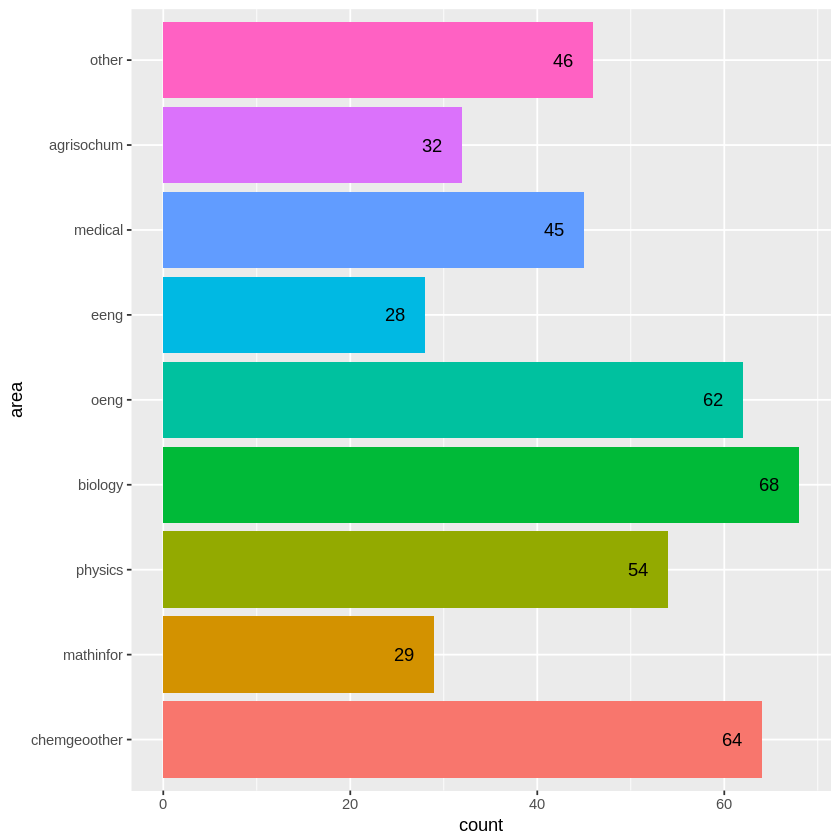

In [25]:
ggplot(tr,aes(area))+geom_bar(aes(fill=area),show.legend = FALSE)+
geom_text(stat='count',aes(label=..count..),hjust=2)+coord_flip()